In [37]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from torchvision.models import resnet18, ResNet18_Weights
from torch.amp import GradScaler, autocast

In [38]:
DATA_DIR = "data/Images"
OUTPUT_DIR = "data/Processed"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 150
LR = 0.001

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [39]:
def load_dataset(data_dir):
    all_paths = glob(os.path.join(data_dir, "*", "*.jpg"))
    all_labels = [os.path.basename(os.path.dirname(p)) for p in all_paths]
    return all_paths, all_labels

def resize_image(image, target_size=IMG_SIZE):
    return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

def normalize_image(image):
    return image.astype(np.float32) / 255.0

def preprocess_image(path, target_size=IMG_SIZE, to_rgb=True, normalize=True):
    img = cv2.imread(path)
    if img is None:
        return None
    if to_rgb:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = resize_image(img, target_size)
    if normalize:
        img = normalize_image(img)
    return img

In [40]:
def split_and_save_dataset(image_paths, labels):
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    SPLIT_RATIOS = {"train": 0.7, "validation": 0.15, "test": 0.15}

    class_to_paths = {}
    for path, label in zip(image_paths, labels):
        class_to_paths.setdefault(label, []).append(path)

    path_to_split = {}
    for label, paths in class_to_paths.items():
        random.shuffle(paths)
        total = len(paths)
        train_end = int(SPLIT_RATIOS["train"] * total)
        val_end = train_end + int(SPLIT_RATIOS["validation"] * total)
        for i, path in enumerate(paths):
            split = "train" if i < train_end else "validation" if i < val_end else "test"
            path_to_split[path] = split

    for split in SPLIT_RATIOS:
        for label in class_to_paths:
            os.makedirs(os.path.join(OUTPUT_DIR, split, label), exist_ok=True)

    for path, label in tqdm(zip(image_paths, labels), total=len(image_paths), desc="Preprocessing"):
        img = preprocess_image(path)
        if img is None:
            print(f"[READ FAIL] {path}")
            continue
        save_img = (img * 255).astype(np.uint8)
        save_img = cv2.cvtColor(save_img, cv2.COLOR_RGB2BGR)
        split = path_to_split.get(path, "train")
        save_dir = os.path.join(OUTPUT_DIR, split, label)
        cv2.imwrite(os.path.join(save_dir, os.path.basename(path)), save_img)

In [41]:
# One-time preprocessing
from pathlib import Path

DATA_DIR = "data/Images"  #in case

if not Path(OUTPUT_DIR, "train").exists():
    print("Running preprocessing...")
    paths, labels = load_dataset(DATA_DIR)
    print(f"Found {len(paths)} images")
    split_and_save_dataset(paths, labels)
    print("Preprocessing done.")
else:
    print("Processed dataset already exists — skipping.")

Running preprocessing...
Found 20580 images


Preprocessing:   0%|          | 0/20580 [00:00<?, ?it/s]

Preprocessing done.


In [42]:
class AddGaussianNoise:
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"

def get_transform_for_epoch(epoch):
    if epoch < 5:
        return transforms.Compose([
            transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    elif epoch < 65:
        return transforms.Compose([
            transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    elif epoch < 130:
        return transforms.Compose([
            transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(p=0.2),
            transforms.RandomRotation(10),
            transforms.ColorJitter(0.2, 0.2, 0.2),
            transforms.RandomGrayscale(p=0.1),
            transforms.ToTensor(),
            transforms.RandomApply([transforms.GaussianBlur(3)], p=0.2),
            transforms.RandomErasing(p=0.2, scale=(0.05, 0.15)),
            transforms.Normalize(mean, std)
        ])
    else:
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomApply([transforms.GaussianBlur(5)], p=0.3),
            transforms.RandomApply([AddGaussianNoise(0., 0.1)], p=0.3),
            transforms.RandomApply([transforms.RandomErasing(p=1.0, scale=(0.1, 0.2))], p=0.3),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(p=0.3),
            transforms.RandomRotation(15),
            transforms.RandomAffine(0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.ColorJitter(0.3, 0.3, 0.3, 0.05),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomAdjustSharpness(2.0, p=0.5),
            transforms.Normalize(mean, std)
        ])

In [43]:
def get_resnet_model(num_classes):
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    in_features = model.fc.in_features
    model.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(in_features, num_classes))
    for param in model.fc.parameters():
        param.requires_grad = True
    return model

In [44]:
def plot_training_convergence(train_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label="Training Loss", color="red")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Loss")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_accuracies, label="Train Acc", color="blue")
    plt.plot(epochs, val_accuracies, label="Val Acc", color="green")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

In [45]:
def evaluate_model(model, dataloader, device="cuda"):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    all_preds, all_labels = np.array(all_preds), np.array(all_labels)
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Accuracy: {acc:.3f}\nPrecision: {prec:.3f}\nRecall: {rec:.3f}\nF1 Score: {f1:.3f}")

    cm = confusion_matrix(all_labels, all_preds)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    class_names = dataloader.dataset.classes
    clean_names = [name.split('-', 1)[-1] for name in class_names]
    top_idx = np.argsort(per_class_acc)

    plt.figure(figsize=(8, 6))
    plt.barh([clean_names[i] for i in top_idx[-15:]], per_class_acc[top_idx[-15:]])
    plt.title("Top 15 Best Performing Classes"); plt.xlabel("Accuracy"); plt.tight_layout(); plt.show()

    plt.figure(figsize=(8, 6))
    plt.barh([clean_names[i] for i in top_idx[:15]], per_class_acc[top_idx[:15]])
    plt.title("Top 15 Worst Performing Classes"); plt.xlabel("Accuracy"); plt.tight_layout(); plt.show()

    metrics = [acc, prec, rec, f1]
    names = ["Accuracy", "Precision", "Recall", "F1 Score"]
    plt.figure(figsize=(6, 4))
    plt.bar(names, metrics, color=['skyblue', 'orange', 'green', 'red'])
    plt.ylim(0, 1); plt.title("Overall Evaluation Metrics"); plt.ylabel("Score")
    for i, v in enumerate(metrics):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
    plt.show()

In [46]:
def train_and_validate():
    train_losses, val_accuracies, train_accuracies = [], [], []
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = get_resnet_model(num_classes=len(os.listdir(os.path.join(OUTPUT_DIR, 'train')))).to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    scaler = GradScaler(device)

    val_ds = datasets.ImageFolder(os.path.join(OUTPUT_DIR, 'validation'), transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]))
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

    best_val_acc = 0
    patience, patience_counter = 5, 0
    unfreeze_at_epoch = 3

    for epoch in range(EPOCHS):
        model.train()
        transform = get_transform_for_epoch(epoch)
        train_ds = datasets.ImageFolder(os.path.join(OUTPUT_DIR, 'train'), transform=transform)
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

        if epoch == unfreeze_at_epoch:
            print(f"Unfreezing backbone at epoch {epoch}")
            for param in model.parameters():
                param.requires_grad = True
            optimizer = optim.Adam(model.parameters(), lr=LR * 0.1, weight_decay=1e-4)
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS - epoch)

        total_loss, correct = 0, 0
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            with autocast(device):
                pred = model(x)
                loss = criterion(pred, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()
            correct += (pred.argmax(1) == y).sum().item()

        train_acc = correct / len(train_ds)
        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(train_acc)

        # Validation
        model.eval(); val_correct = 0; val_total = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                preds = model(x_val)
                val_correct += (preds.argmax(1) == y_val).sum().item()
                val_total += y_val.size(0)
        val_acc = val_correct / val_total
        val_accuracies.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

        print(f"Epoch {epoch+1}: Loss={total_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, LR={scheduler.get_last_lr()[0]:.6f}")
        scheduler.step()

    torch.save(model.state_dict(), "model.pth")
    print("Model saved.")
    return train_losses, train_accuracies, val_accuracies

Epoch 1/150:   0%|          | 0/449 [00:00<?, ?it/s]

Epoch 1: Loss=1423.3245, Train Acc=0.3405, Val Acc=0.6519, LR=0.001000


Epoch 2/150:   0%|          | 0/449 [00:00<?, ?it/s]

Epoch 2: Loss=1028.5941, Train Acc=0.5571, Val Acc=0.6969, LR=0.001000


Epoch 3/150:   0%|          | 0/449 [00:00<?, ?it/s]

Epoch 3: Loss=984.9703, Train Acc=0.5928, Val Acc=0.7045, LR=0.001000
Unfreezing backbone at epoch 3


Epoch 4/150:   0%|          | 0/449 [00:00<?, ?it/s]

Epoch 4: Loss=912.2440, Train Acc=0.6458, Val Acc=0.7438, LR=0.000100


Epoch 5/150:   0%|          | 0/449 [00:00<?, ?it/s]

Epoch 5: Loss=802.7841, Train Acc=0.7292, Val Acc=0.7412, LR=0.000100


Epoch 6/150:   0%|          | 0/449 [00:00<?, ?it/s]

Epoch 6: Loss=735.8013, Train Acc=0.7838, Val Acc=0.7451, LR=0.000100


Epoch 7/150:   0%|          | 0/449 [00:00<?, ?it/s]

Epoch 7: Loss=682.9907, Train Acc=0.8292, Val Acc=0.7392, LR=0.000100


Epoch 8/150:   0%|          | 0/449 [00:00<?, ?it/s]

Epoch 8: Loss=642.1838, Train Acc=0.8639, Val Acc=0.7537, LR=0.000100


Epoch 9/150:   0%|          | 0/449 [00:00<?, ?it/s]

Epoch 9: Loss=607.9675, Train Acc=0.8931, Val Acc=0.7531, LR=0.000100


Epoch 10/150:   0%|          | 0/449 [00:00<?, ?it/s]

Epoch 10: Loss=583.8160, Train Acc=0.9165, Val Acc=0.7494, LR=0.000100


Epoch 11/150:   0%|          | 0/449 [00:00<?, ?it/s]

Epoch 11: Loss=562.0446, Train Acc=0.9340, Val Acc=0.7488, LR=0.000099


Epoch 12/150:   0%|          | 0/449 [00:00<?, ?it/s]

Epoch 12: Loss=542.4731, Train Acc=0.9471, Val Acc=0.7471, LR=0.000099


Epoch 13/150:   0%|          | 0/449 [00:00<?, ?it/s]

Early stopping triggered.
Model saved.


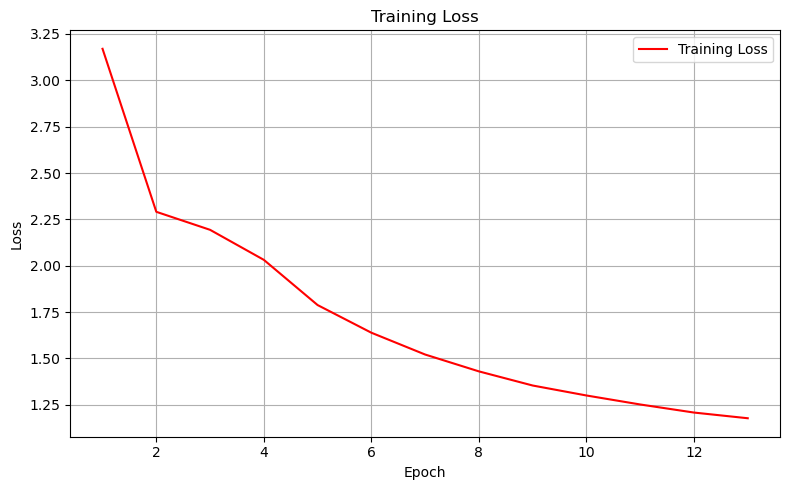

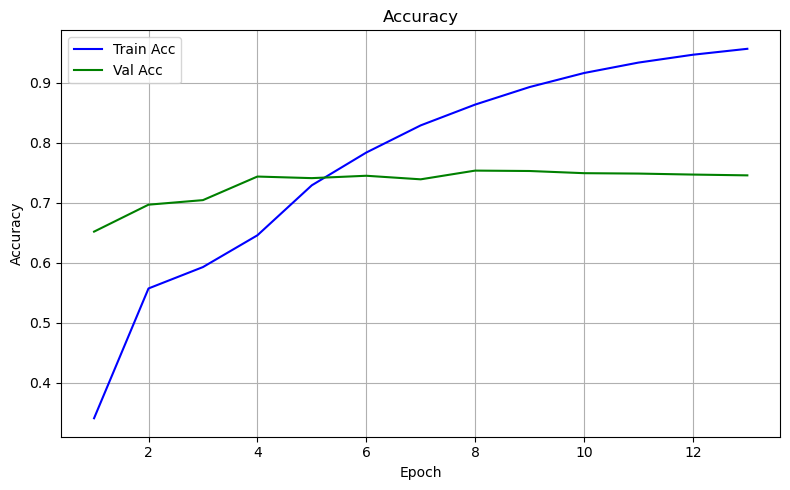

In [47]:
train_losses, train_accuracies, val_accuracies = train_and_validate()
plot_training_convergence(train_losses, train_accuracies, val_accuracies)

C:\Users\Codfi\AppData\Local\Temp\ipykernel_18936\343504484.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_locat

Accuracy: 0.754
Precision: 0.760
Recall: 0.749
F1 Score: 0.748


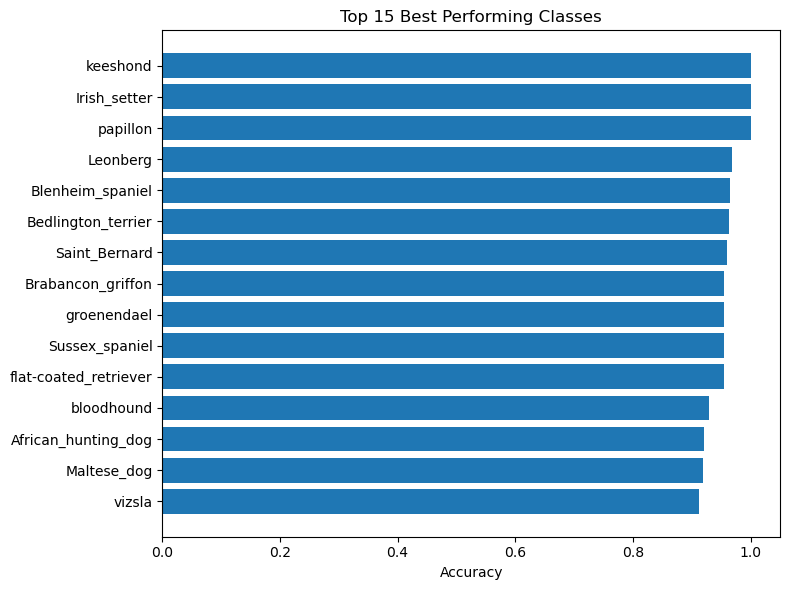

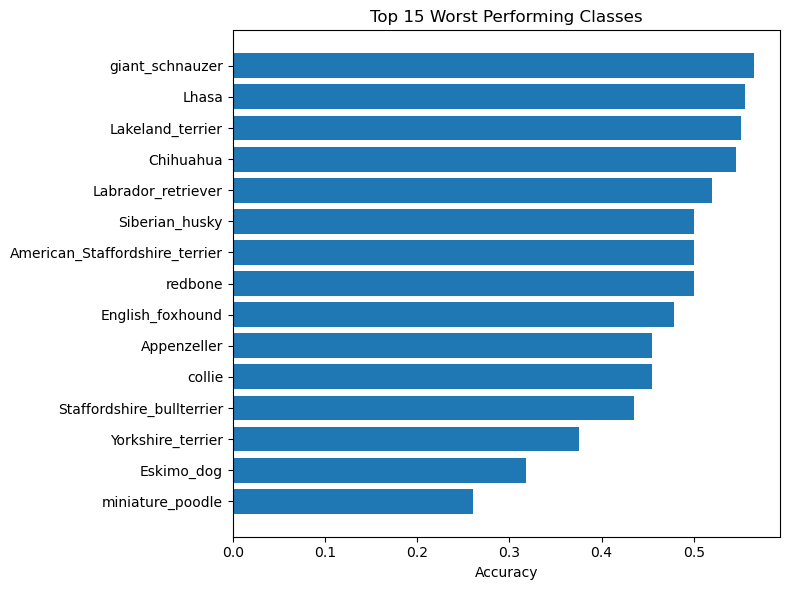

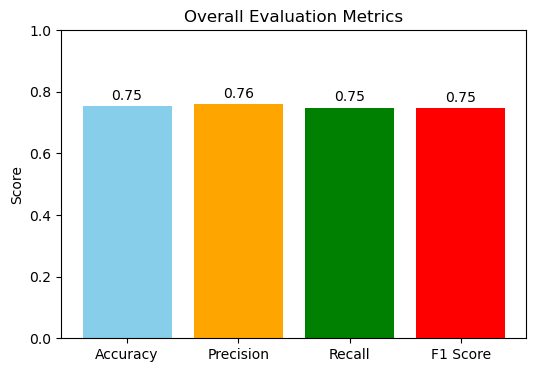

In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"

val_ds = datasets.ImageFolder(os.path.join(OUTPUT_DIR, 'validation'), transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
]))
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

model = get_resnet_model(num_classes=len(val_loader.dataset.classes)).to(device)
model.load_state_dict(torch.load("best_model.pth", map_location=device))

evaluate_model(model, val_loader, device)